## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [191]:
%pip install pandas
%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should follow the format %pip install PACKAGE_NAME

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

In [192]:
###...code...###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



df= pd.read_csv(r"./Monthly Data.csv")

df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,7/1/2024,19988.217,16306.3,120.966,1.529744e+06,710851.00000,102.5340,100.5549,100.3012,101.3681,...,119.776,127.972,31.20,35.70,27.96,66.4,548691.61,930374.96,5278.3525,14.4084
788,8/1/2024,20007.209,16322.1,121.052,1.530317e+06,710038.00000,103.0831,101.0481,101.0128,102.2410,...,119.653,128.291,31.26,35.81,27.97,67.9,551667.22,933066.90,5327.6461,19.6750
789,9/1/2024,20044.142,16333.7,121.690,1.541305e+06,716388.00000,102.5283,100.1897,99.8299,101.6286,...,119.220,128.682,31.44,36.00,28.11,70.1,553347.06,934283.59,5368.5924,17.6597
790,10/1/2024,20131.843,16394.9,121.837,1.539243e+06,719676.00000,102.1123,99.5930,99.0546,101.5048,...,119.073,129.148,31.57,36.22,28.18,70.5,554377.25,937299.96,5407.4120,19.9478


In [193]:
# # Plot the First 10 Columns Against `sasdate`
# plt.figure(figsize=(15, 10))  # Set the figure size

# # Loop through the first 10 columns and plot each against `sasdate`
# for i in range(1, 11):
#     plt.plot(df['sasdate'], df.iloc[:, i], label=df.columns[i])

# plt.xlabel('sasdate')  # Set the x-axis label
# plt.ylabel('Values')  # Set the y-axis label
# plt.title('First 10 Columns vs sasdate')  # Set the plot title
# plt.legend()  # Add a legend
# plt.show()  # Display the plot

In [194]:
df.describe()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
count,792.000000,792.000000,792.000000,7.910000e+02,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,...,792.000000,792.000000,792.000000,792.000000,792.000000,638.000000,791.000000,791.000000,792.000000,750.000000
mean,9547.034388,8130.542803,56.544340,8.224117e+05,222509.456076,67.560177,71.804264,70.581599,79.081315,66.653835,...,63.075617,53.711013,12.713561,14.756010,11.725492,85.019122,138221.790329,353128.169987,1331.897868,19.277022
std,5063.517898,4011.031615,30.668647,3.855208e+05,189010.037672,26.915001,27.268114,27.537838,23.542982,28.718980,...,31.120557,34.223879,7.959663,8.931801,7.155517,13.442433,140306.181759,338194.732904,1483.113646,7.096851
min,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,6.000000,6.000000,2.130000,2.450000,2.040000,2.000000,6.000000,6.000000,6.000000,1.000000
25%,5145.454000,4569.650000,28.907750,4.877999e+05,50691.054080,44.904150,47.042050,44.855025,61.332075,42.170650,...,32.665750,19.197250,5.105000,6.785000,4.702500,75.000000,10811.000000,34131.000000,186.727850,14.261675
50%,8331.325500,7262.200000,48.330000,7.200715e+05,161847.549500,62.589400,71.524600,69.607650,80.995550,61.171950,...,67.132000,51.702000,11.860000,13.685000,11.255000,88.950000,80546.000000,189012.920000,720.603650,17.624250
75%,13766.290250,11448.950000,84.203250,1.176456e+06,358024.750000,95.334100,99.273350,98.456325,100.474200,97.597275,...,91.199250,83.747500,19.230000,21.760000,17.707500,94.700000,267126.120000,728821.575000,2084.900000,22.526075
max,22850.332000,16433.700000,122.173000,1.541305e+06,724609.000000,104.103800,110.212000,108.675800,111.757500,109.816700,...,120.190000,129.363000,31.630000,36.220000,28.300000,112.000000,554377.250000,949306.220000,5831.233000,62.964800


In [195]:
# Load the new DataFrame
df_quarterly = pd.read_csv(r"./Quarterly Data.csv")
# Delete the first two rows (row 0 and row 1) from df_quarterly
df_quarterly = df_quarterly.drop([0, 1]).reset_index(drop=True)

# Display the first few rows to verify the deletion
df_quarterly.head()
# Display the first few rows of the new DataFrame
df_quarterly.head()

,sasdate,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,...,TNWMVBSNNCBBDIx,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P div yield,S&P PE ratio
0,3/1/1959,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,...,1341.67,333245.24,266668.11,2426352.41,2092.54,1674.48,124.9663,55.5167,3.1765,18.6211
1,6/1/1959,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,...,1294.15,345845.01,273329.36,2434975.21,2088.55,1650.63,126.5305,57.5067,3.1012,19.2899
2,9/1/1959,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,...,1320.72,354808.05,275139.48,2434604.03,2079.21,1612.34,128.9557,58.7300,3.0720,18.9544
3,12/1/1959,3439.832,2094.495,69.1573,1430.8157,701.7617,369.442,367.6452,50.7342,180.2333,...,1165.65,349400.81,254967.79,2429055.21,2079.05,1517.14,137.0372,57.7633,3.1572,17.8221
4,3/1/1960,3517.181,2114.532,71.3815,1443.7405,703.5338,406.581,379.9162,52.4985,186.4967,...,1327.63,362821.95,278692.55,2451394.44,2087.97,1603.82,130.1872,56.2767,3.3850,16.8284


# Adding percentage change columns, converting to datetime

In [196]:
# Create percentage change columns for every column in df_quarterly
for column in df_quarterly.columns:
    if column != 'sasdate' :  # Skip the 'sasdate' column
        df_quarterly[column + '_pct_change'] = df_quarterly[column].pct_change()*100

#convert to datetime
df_quarterly['sasdate'] = pd.to_datetime(df_quarterly['sasdate'])

# Display the first few rows to verify the new columns
df_quarterly.head()

C:\Users\tanke\AppData\Local\Temp\ipykernel_21352\711358037.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_quarterly[column + '_pct_change'] = df_quarterly[column].pct_change()*100
C:\Users\tanke\AppData\Local\Temp\ipykernel_21352\711358037.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_quarterly[column + '_pct_change'] = df_quarterly[column].pct_change()*100
C:\Users\tanke\AppData\Local\Temp\ipykernel_21352\711358037.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

,sasdate,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,...,TNWMVBSNNCBBDIx_pct_change,TLBSNNBx_pct_change,TLBSNNBBDIx_pct_change,TABSNNBx_pct_change,TNWBSNNBx_pct_change,TNWBSNNBBDIx_pct_change,CNCFx_pct_change,S&P 500_pct_change,S&P div yield_pct_change,S&P PE ratio_pct_change
0,1959-03-01,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1959-06-01,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,...,-3.541855,3.780930,2.497955,0.355381,-0.190677,-1.424323,1.251697,3.584507,-2.370534,3.591625
2,1959-09-01,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,...,2.053085,2.591635,0.662249,-0.015244,-0.447200,-2.319720,1.916692,2.127230,-0.941571,-1.739252
3,1959-12-01,3439.832,2094.495,69.1573,1430.8157,701.7617,369.442,367.6452,50.7342,180.2333,...,-11.741323,-1.523990,-7.331441,-0.227915,-0.007695,-5.904462,6.266881,-1.646007,2.773438,-5.973811
4,1960-03-01,3517.181,2114.532,71.3815,1443.7405,703.5338,406.581,379.9162,52.4985,186.4967,...,13.896109,3.841187,9.305003,0.919667,0.429042,5.713382,-4.998643,-2.573606,7.215254,-5.575662


# Plotting graph of GDPC1 pct change

<Axes: xlabel='sasdate', ylabel='GDPC1_pct_change'>

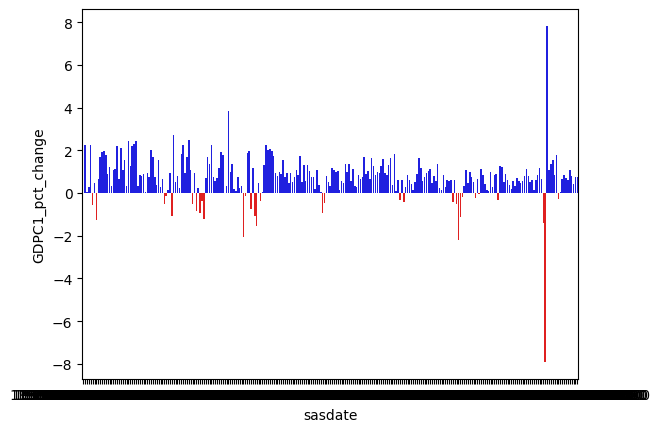

In [197]:
sns.barplot(data=df_quarterly, x='sasdate', y='GDPC1_pct_change')
# Create a custom color palette

colors = ['red' if val < 0 else 'blue' for val in df_quarterly['GDPC1_pct_change']]

# Plot the bar plot with custom colors
sns.barplot(data=df_quarterly, x='sasdate', y='GDPC1_pct_change', palette=colors)

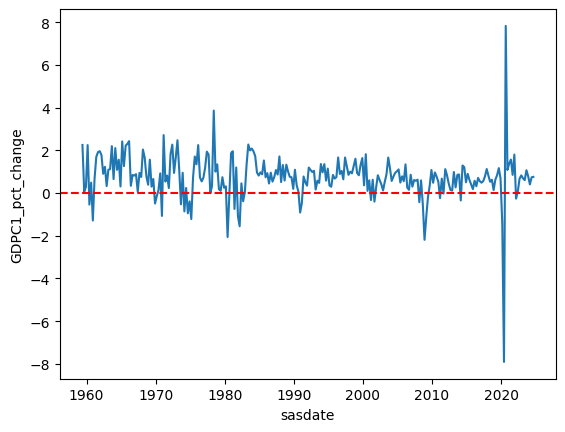

In [198]:
sns.lineplot(data=df_quarterly, x='sasdate', y='GDPC1_pct_change')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Displaying GDP growth rate 2008 recession 

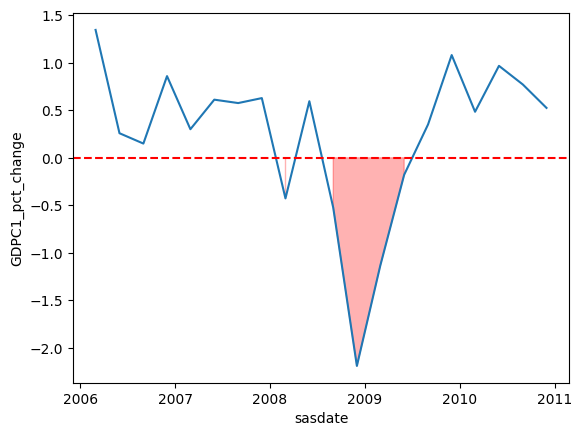

In [199]:
# Convert 'sasdate' to datetime format
df_quarterly['sasdate'] = pd.to_datetime(df_quarterly['sasdate'])

# Filter the DataFrame for the time range from 2006 to 2010
df_quarterly_filtered = df_quarterly[(df_quarterly['sasdate'] >= '2006-01-01') & (df_quarterly['sasdate'] <= '2010-12-31')]

# Plot the filtered data
sns.lineplot(data=df_quarterly_filtered, x='sasdate', y='GDPC1_pct_change')
plt.axhline(0, color='red', linestyle='--')
plt.fill_between(df_quarterly_filtered['sasdate'], df_quarterly_filtered['GDPC1_pct_change'], where=(df_quarterly_filtered['GDPC1_pct_change'] < 0), color='red', alpha=0.3)
plt.show()

#### Remember to rename your file name to **NUS_DSESC_DATABUSTERS_XX.ipynb** and ensure that it can run successfully. Good luck and have fun!

# Trying to change map column names to variable description T_T

In [200]:
df2= pd.read_csv(r"./Variable Description.csv", encoding='latin1')


In [201]:
new_col=df2[['FRED MNEMONIC', 'DESCRIPTION']].set_index('FRED MNEMONIC').to_dict()['DESCRIPTION']

In [202]:
df3= df_quarterly.rename(columns=new_col)

In [203]:
df3

,sasdate,"Real Gross Domestic Product, 3 Decimal (Billions of Chained 2017 Dollars)",Real Personal Consumption Expenditures (Billions of Chained 2017 Dollars),"Real personal consumption expenditures: Durable goods (Billions of Chained 2017 Dollars), deflated using its own price index","Real Personal Consumption Expenditures: Services (Billions of 2017 Dollars), deflated using its own price index","Real Personal Consumption Expenditures: Nondurable Goods (Billions of 2017 Dollars), deflated using its own price index","Real Gross Private Domestic Investment, 3 decimal (Billions of Chained 2017 Dollars)","Real private fixed investment (Billions of Chained 2017 Dollars), deflated using its own price index","Real Gross Private Domestic Investment: Fixed Investment: Nonresidential: Equipment (Billions of Chained 2017 Dollars), deflated using its own price index","Real private fixed investment: Nonresidential (Billions of Chained 2017 Dollars), deflated using its own price index",...,TNWMVBSNNCBBDIx_pct_change,TLBSNNBx_pct_change,TLBSNNBBDIx_pct_change,TABSNNBx_pct_change,TNWBSNNBx_pct_change,TNWBSNNBBDIx_pct_change,CNCFx_pct_change,S&P 500_pct_change,S&P div yield_pct_change,S&P PE ratio_pct_change
0,1959-03-01,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1959-06-01,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,...,-3.541855,3.780930,2.497955,0.355381,-0.190677,-1.424323,1.251697,3.584507,-2.370534,3.591625
2,1959-09-01,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,...,2.053085,2.591635,0.662249,-0.015244,-0.447200,-2.319720,1.916692,2.127230,-0.941571,-1.739252
3,1959-12-01,3439.832,2094.495,69.1573,1430.8157,701.7617,369.442,367.6452,50.7342,180.2333,...,-11.741323,-1.523990,-7.331441,-0.227915,-0.007695,-5.904462,6.266881,-1.646007,2.773438,-5.973811
4,1960-03-01,3517.181,2114.532,71.3815,1443.7405,703.5338,406.581,379.9162,52.4985,186.4967,...,13.896109,3.841187,9.305003,0.919667,0.429042,5.713382,-4.998643,-2.573606,7.215254,-5.575662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2023-09-01,22780.933,15646.695,1990.6487,10332.6348,3351.4410,4237.303,4128.6899,1292.2791,3400.8598,...,-6.640866,-0.320564,-4.287493,-0.715501,-0.991930,-4.932873,4.144632,6.037654,-4.947581,7.785060
259,2023-12-01,22960.600,15781.367,2004.7389,10422.9997,3381.4939,4244.835,4164.7073,1294.6535,3432.9110,...,-3.720901,0.164435,-3.652741,-1.879873,-3.540146,-7.215495,3.961892,0.298851,1.064241,1.202904
260,2024-03-01,23053.545,15856.867,1995.8869,10510.6699,3374.3097,4282.515,4231.1675,1295.7560,3470.9873,...,5.134762,0.005830,3.767449,-0.907412,-1.656941,2.040974,-3.625043,11.805352,-9.738975,9.100061
261,2024-06-01,23223.906,15967.266,2022.5443,10582.0770,3388.3416,4369.185,4255.4844,1326.4911,3504.1342,...,-4.585327,0.141249,-4.011640,0.103405,0.040503,-4.108471,4.326448,5.098766,-3.613095,2.429341


In [204]:
df3['Real private fixed investment: Nonresidential (Billions of Chained 2017 Dollars), deflated using its own price index']

0       171.0783
1       176.0004
2       180.7406
3       180.2333
4       186.4967
         ...    
258    3400.8598
259    3432.9110
260    3470.9873
261    3504.1342
262    3538.8075
Name: Real private fixed investment: Nonresidential (Billions of Chained 2017 Dollars), deflated using its own price index, Length: 263, dtype: float64